In [1292]:
timestamp()

##------ Mon Mar 23 09:46:46 2020 ------##


In [1293]:
library(tidyverse)
library(lubridate)
theme_set(theme_bw())
options(repr.plot.height=10, repr.plot.width=10)

In [1294]:
PATH = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series"
FILE_TEMPLATE = "time_series_19-covid-%s.csv"
make_path = function(path, file_template, filetype) {
    file = sprintf(file_template, filetype)
    return(sprintf('%s/%s', path, file))
    }

confirmed_path = make_path(PATH, FILE_TEMPLATE, 'Confirmed')
deaths_path = make_path(PATH, FILE_TEMPLATE, 'Deaths')
recovered_path = make_path(PATH, FILE_TEMPLATE, 'Recovered')

confirmed_raw = read.csv(confirmed_path, header=T, as.is=T)
deaths_raw = read.csv(deaths_path, header=T, as.is=T)
recovered_raw = read.csv(recovered_path, header=T, as.is=T)

In [1295]:
prepare_file = function(file, value_name) {
    file = select(file, -c(Lat, Long))
    tmp = pivot_longer(file, 
                       names_to='date', 
                       values_to=value_name,
                       cols=-c('Province.State', 'Country.Region'),
                       names_prefix='X')
    tmp = mutate(tmp, 
                 date=mdy(date)
                )
    tmp$Province.State[tmp$Province.State == ''] = 'None'
    names(tmp)[c(1,2)] = c('state', 'country')
    return(tmp)
}

confirmed = prepare_file(confirmed_raw, 'confirmed')
deaths = prepare_file(deaths_raw, 'deaths')
recovered = prepare_file(recovered_raw, 'recovered')

dat = inner_join(inner_join(confirmed, 
                            deaths, 
                            by=c("state", "country", "date")), 
                 recovered, c("state", "country", "date"))  %>%
filter(!is.na(date)) %>%
mutate(days = as.numeric(date - min(date)))

In [1309]:
STATES_WITH_ABBREV = 
list(c('California', 'CA'),
c('New York', 'NY'),
c('New Jersey', 'NJ'),
c('Washington', 'WA'),
c('Massachusetts', 'MA'),
c('Louisiana', 'LA'),
c('Colorado', 'CO'),
c('Florida', 'FL'),
c('Illinois', 'IL'),
c('Georgia', 'GA'),
c('Texas', 'TX'),
c('Pennsylvania', 'PA'),
c('Tennessee', 'TN'),
c('Wisconsin', 'WI'),
c('Ohio', 'OH'),
c('Michigan', 'MI'))

STATE_ABBREV_MAP = as.data.frame(do.call(rbind, STATES_WITH_ABBREV))
names(STATE_ABBREV_MAP) = c('state', 'state_abbrev')
STATE_ABBREV_MAP = mutate(STATE_ABBREV_MAP,
                          state=as.character(state),
                          state_abbrev=as.character(state_abbrev))

In [1310]:
# attach the right state abbreviation in cases where the counts are given for a whole state
STATE_ABBREVS = unique(STATE_ABBREV_MAP$state_abbrev)


dat_state = filter(dat, country=='US') %>%
                        left_join(STATE_ABBREV_MAP, 
                                  by='state') 


In [1311]:
# attach the right state abbreviation in cases where the counts are given for part of a state
insert_abbrev = function(long_name, abbrev, target_vector) {
    # for each element of long_name matching abbrev, 
    # replaces target_vector with abbrev
    target_vector[grep(abbrev, long_name)] = abbrev
    return(target_vector)
}

for(abbrev in STATE_ABBREVS) {
    dat_state$state_abbrev = insert_abbrev(dat_state$state, 
                                           abbrev, 
                                           dat_state$state_abbrev)
}

country_level = group_by(dat, country, date, days) %>%
summarize(confirmed=sum(confirmed),
          deaths=sum(deaths),
          recovered=sum(recovered)) %>%
mutate(death_rate = deaths / confirmed, # yes I know this is a naive estimate
       recovery_rate = recovered / confirmed)

state_level = filter(dat_state, 
                     !is.na(state_abbrev)) %>%
group_by(state_abbrev, date, days) %>%
summarize(confirmed=sum(confirmed),
          deaths=sum(deaths),
          recovered=sum(recovered)) %>%
mutate(death_rate = deaths / confirmed,
       recovery_rate = recovered / confirmed)


In [1312]:
# some constants to use for plotting and modeling
PER_COUNTRY_CONFIRMED_CASES_MINIMUM = 1000 # show only countries with at least this many confirmed cases
PER_DAY_CONFIRMED_CASES_MINIMUM = 20 # plot / model only the time series with at least this many confirmed cases
PER_DAY_DEATHS_MINIMUM = 1 # plot / model only the time series with at least this many confirmed cases
CONFIRMED_CASES_MINIMUM_TO_SHOW_DEATH_RATE = 200 # plot death rates only when confirmed cases is at least this
FORECAST_HORIZON = 3 
# how many days ahead to forecast




In [1313]:
COUNTRIES = unique(country_level$country[!is.na(country_level$confirmed) &
                                         country_level$confirmed >= 
                                         PER_COUNTRY_CONFIRMED_CASES_MINIMUM])


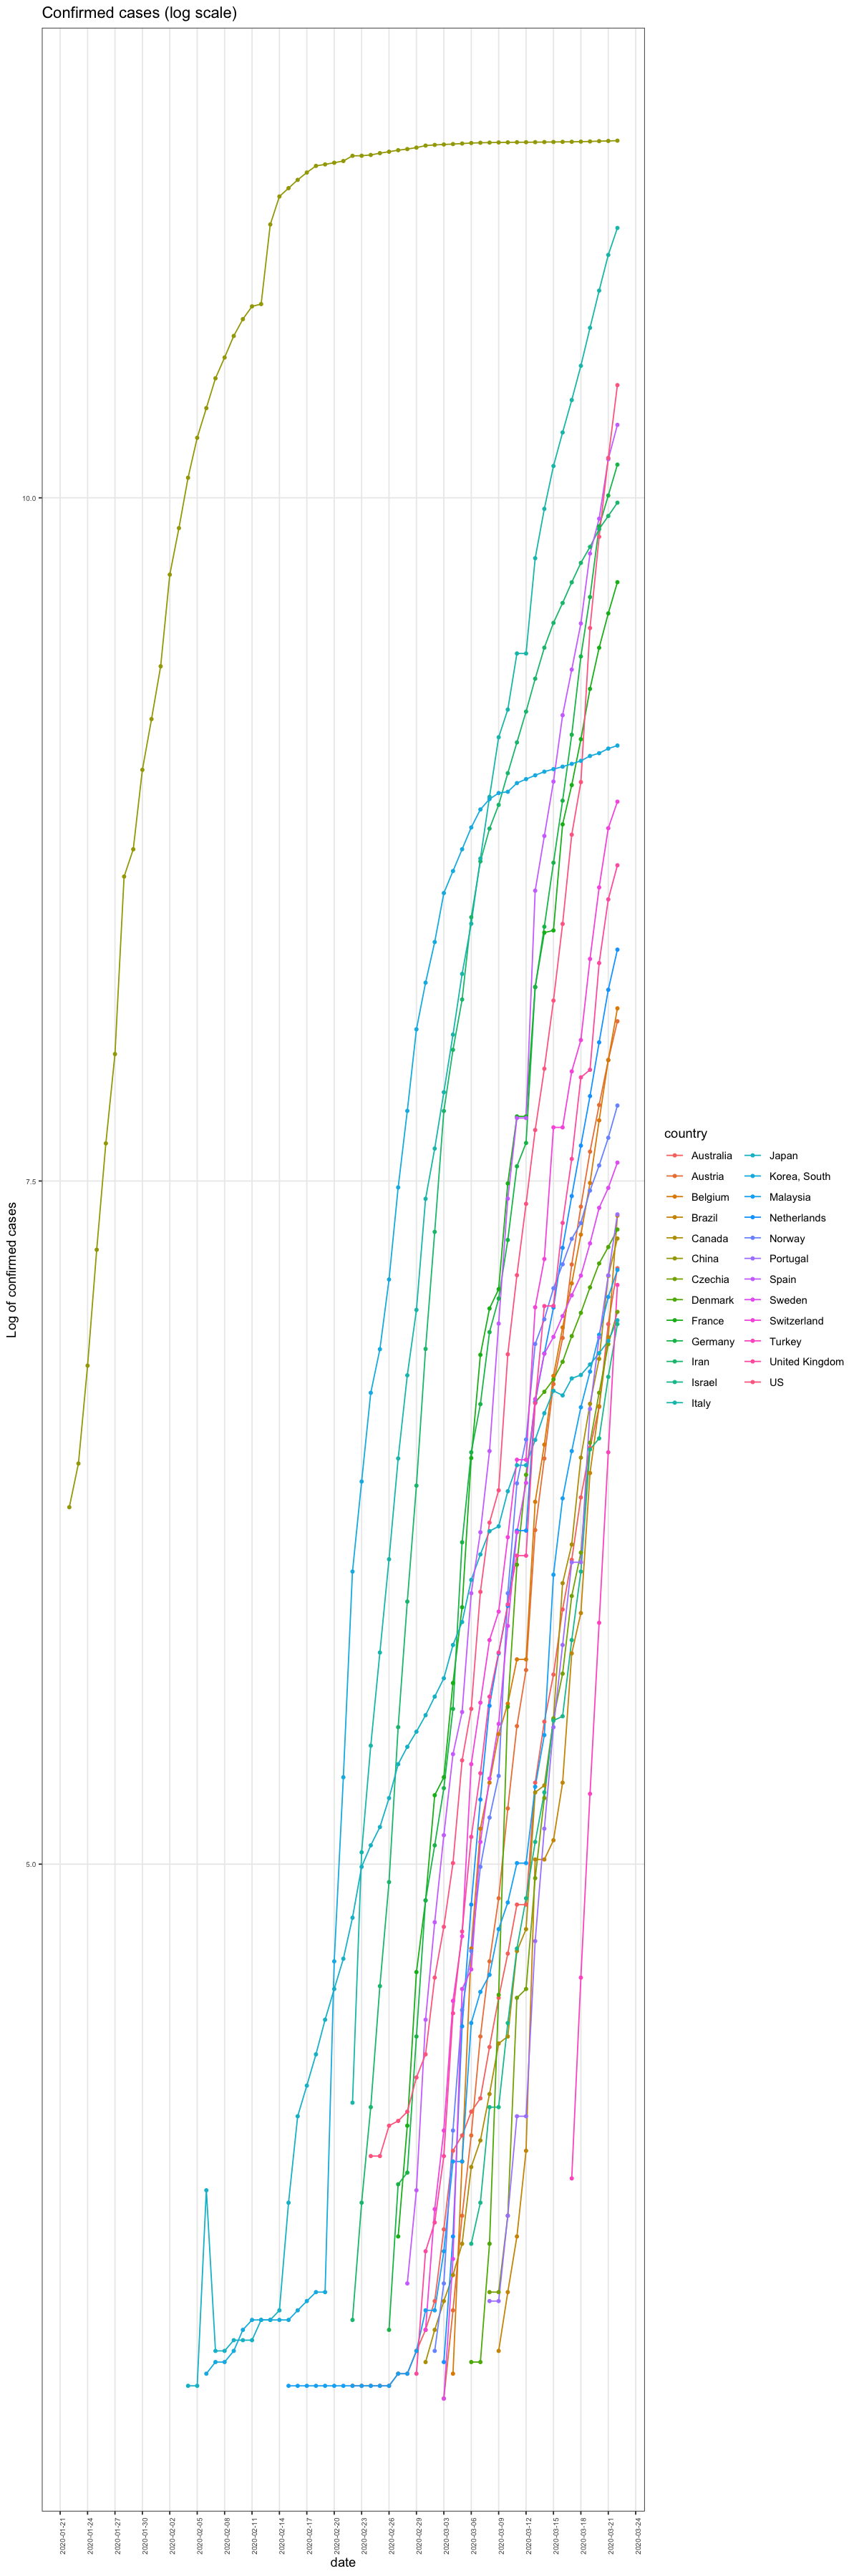

In [1314]:
filter(country_level, 
       country %in% COUNTRIES, confirmed > 
       PER_DAY_CONFIRMED_CASES_MINIMUM) %>%
ggplot(aes(x=date, y=log(confirmed), color=country)) + geom_line() + geom_point(size=1) +
ylab('Log of confirmed cases') +
scale_x_date(date_breaks='3 days') +
theme(axis.text=element_text(size=6),
      axis.text.x = element_text(angle = 90, hjust = 1),
      panel.grid.minor=element_blank())+
ggtitle("Confirmed cases (log scale)")

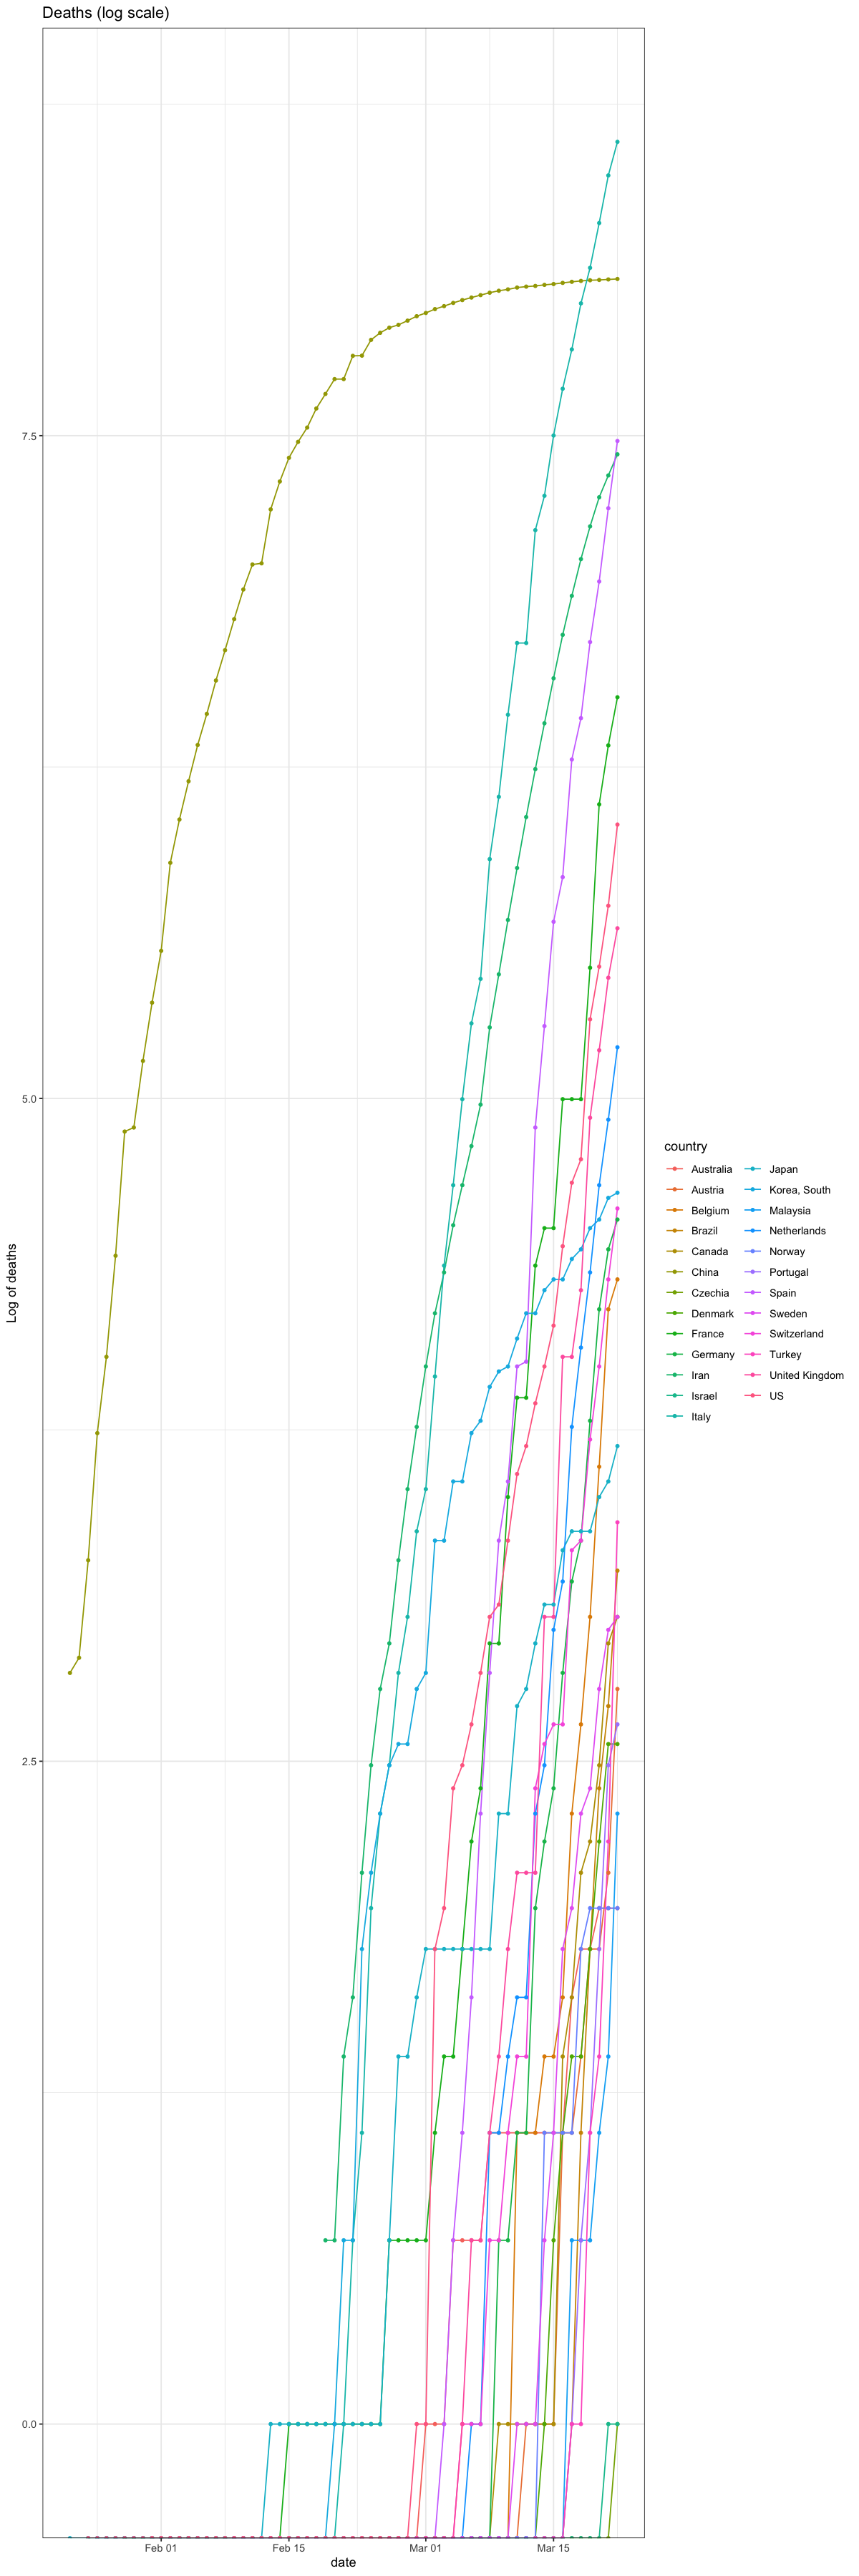

In [1315]:
filter(country_level, 
       country %in% COUNTRIES, confirmed > 
       PER_DAY_DEATHS_MINIMUM) %>%
ggplot(aes(x=date, y=log(deaths), color=country)) + geom_line() + geom_point(size=1) +
ylab('Log of deaths') +
ggtitle("Deaths (log scale)")

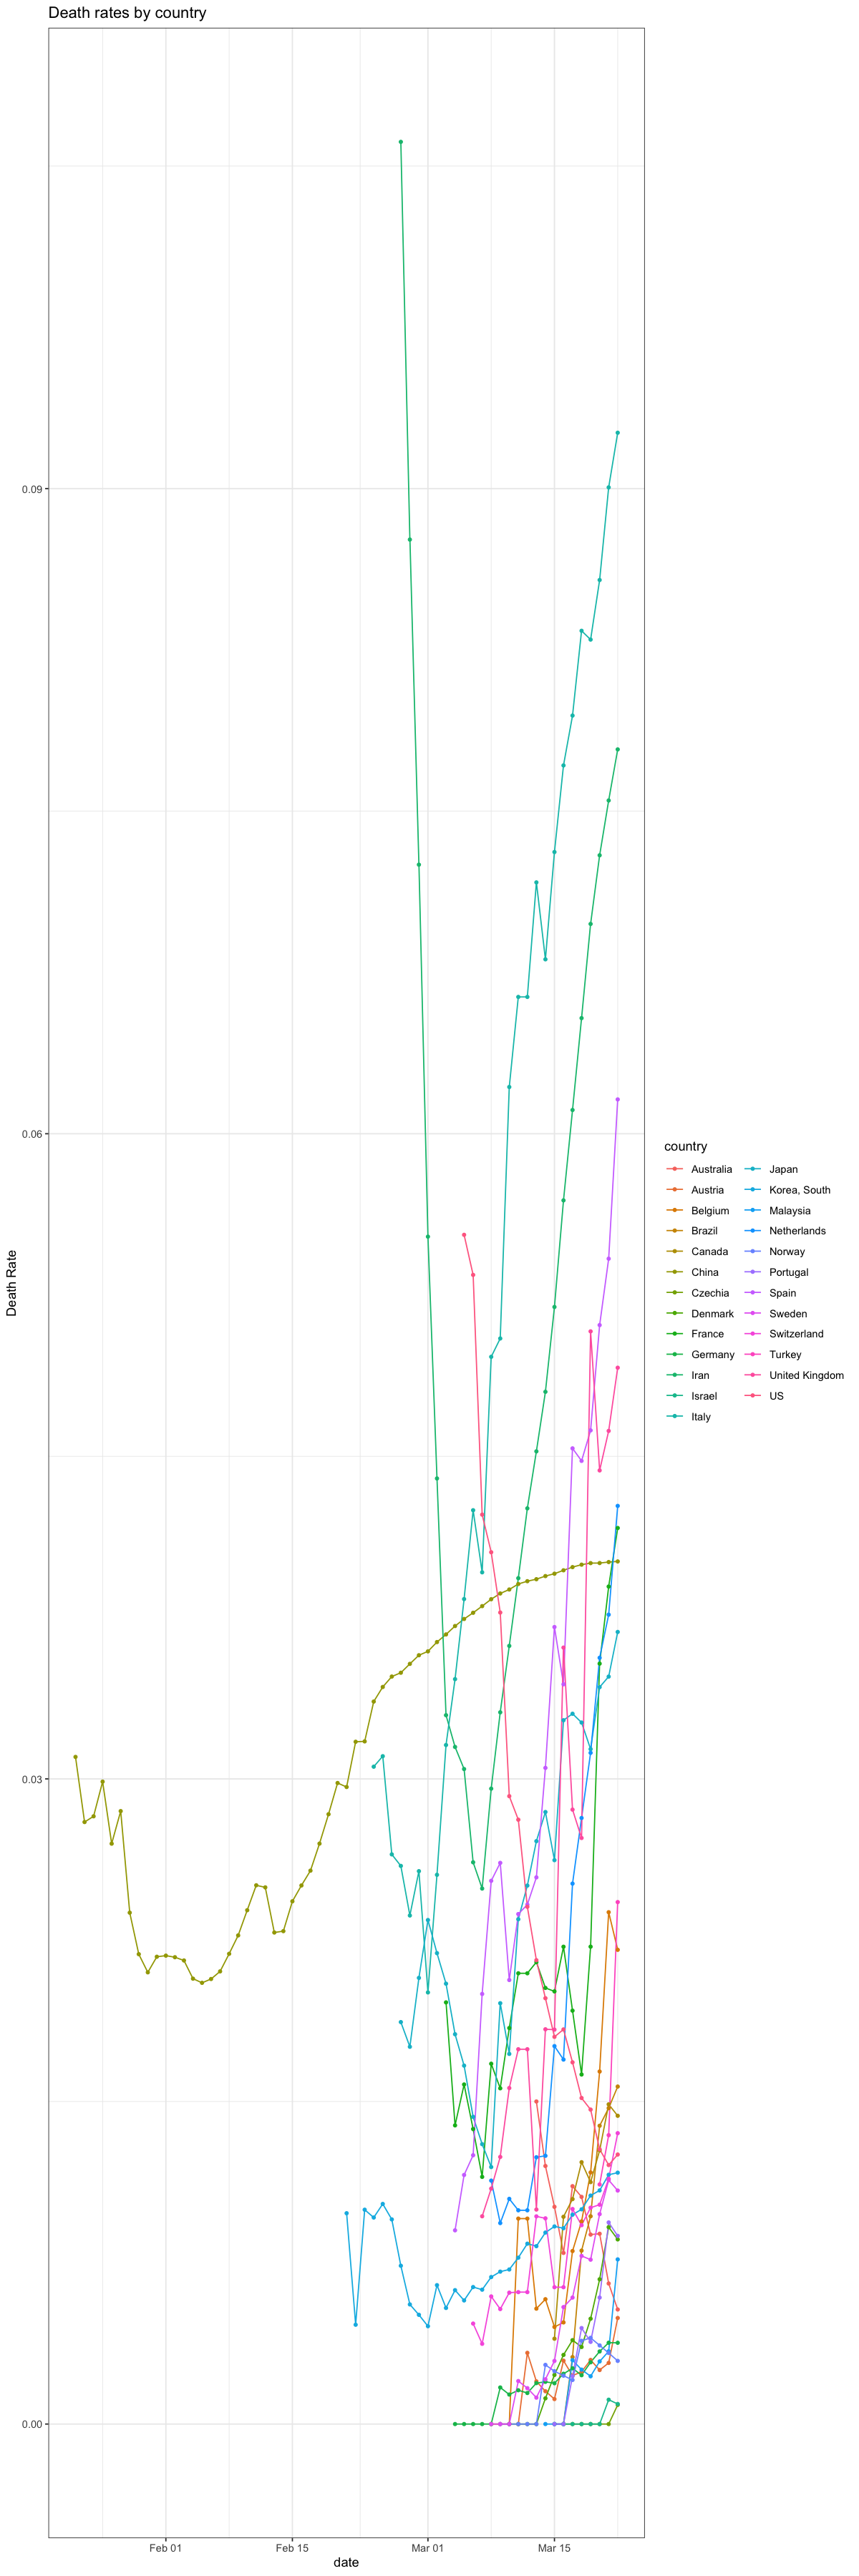

In [1316]:
filter(country_level, country %in% COUNTRIES, 
       confirmed >= CONFIRMED_CASES_MINIMUM_TO_SHOW_DEATH_RATE) %>%
ggplot(aes(x=date, y=death_rate, color=country)) + geom_line() + geom_point(size=1) +
ylab('Death Rate') +
ggtitle("Death rates by country")

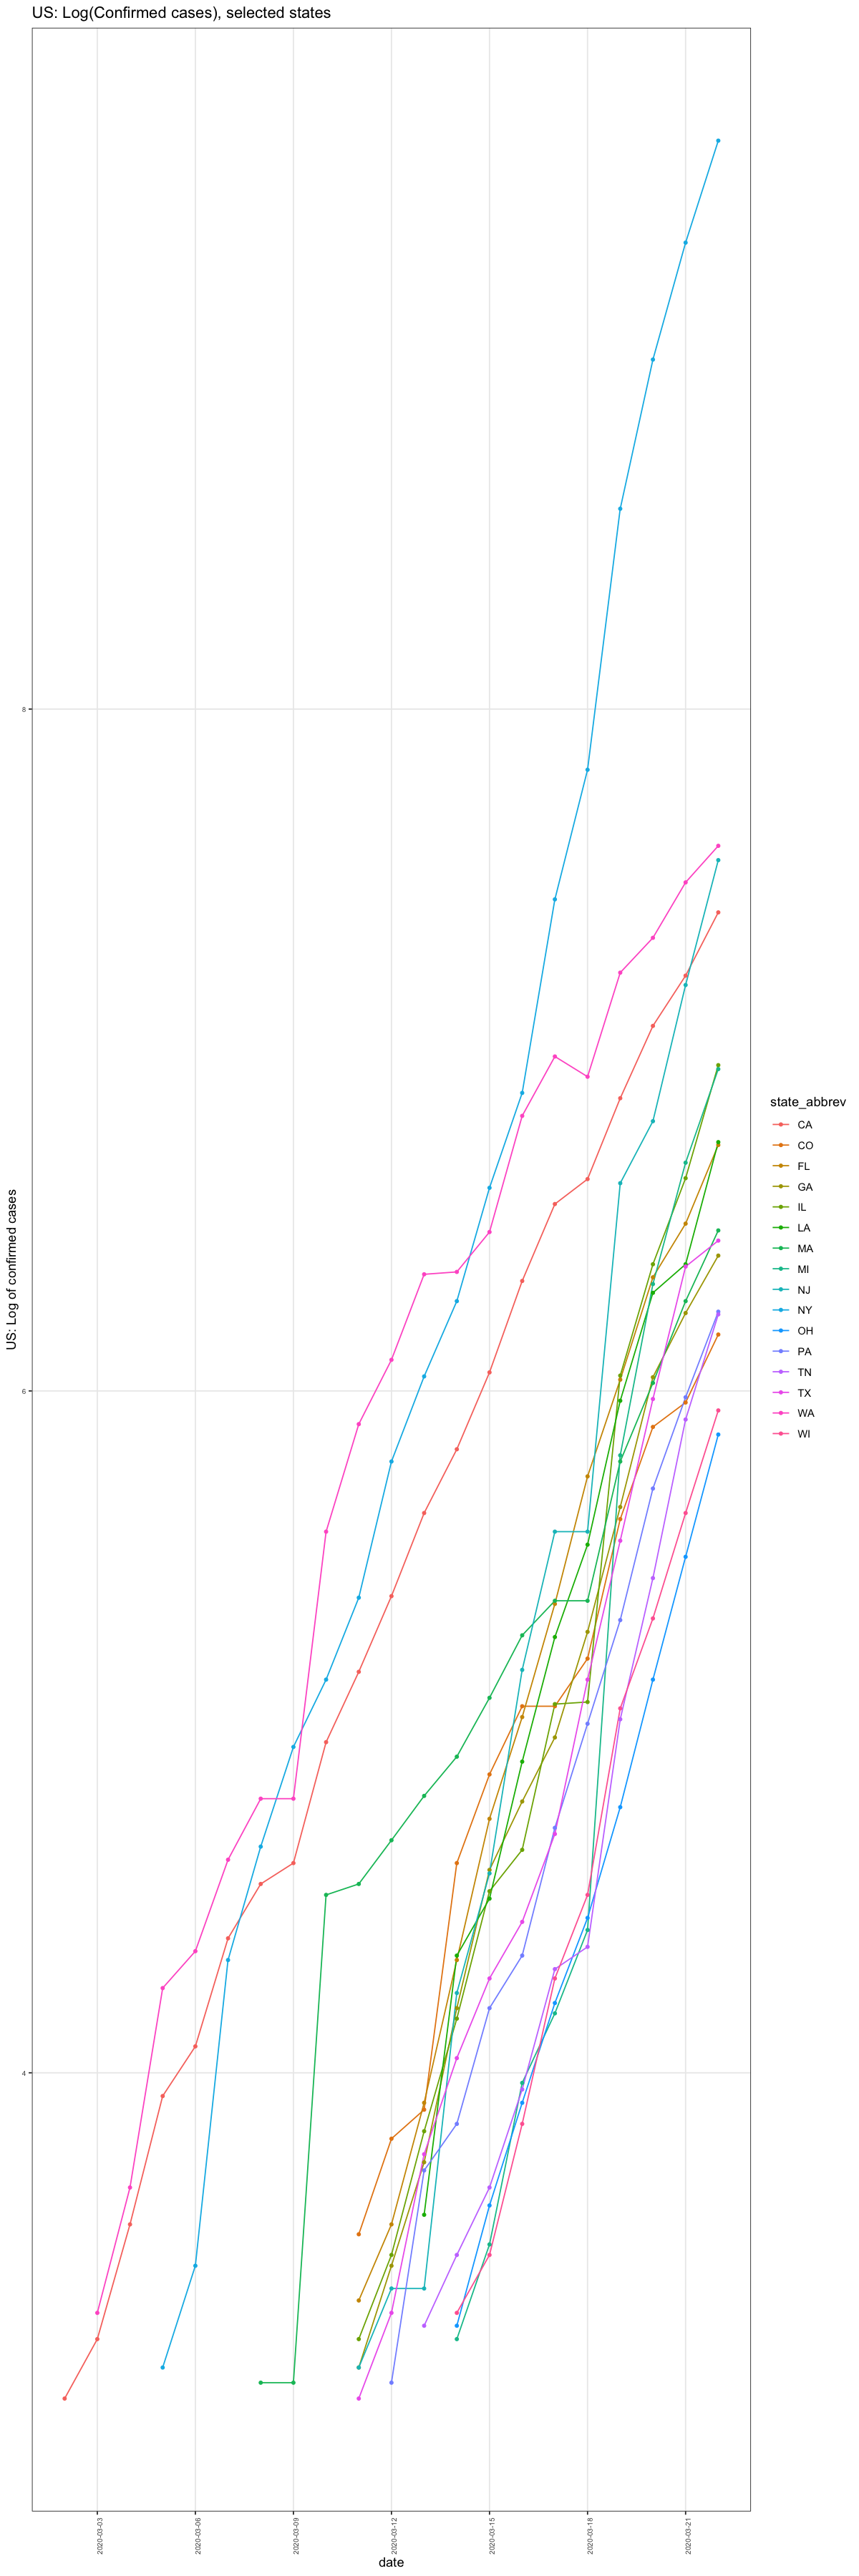

In [1317]:
filter(state_level,
       confirmed >= PER_DAY_CONFIRMED_CASES_MINIMUM, 
       !is.na(state_abbrev) ) %>%
ggplot(aes(x=date, y=log(confirmed), color=state_abbrev)) + geom_line() + geom_point(size=1) +
ylab('US: Log of confirmed cases') +
scale_x_date(date_breaks='3 days') +
ggtitle("US: Log(Confirmed cases), selected states") +
theme(axis.text=element_text(size=6),
      axis.text.x = element_text(angle = 90, hjust = 1),
      panel.grid.minor=element_blank())

In [1318]:
forecast_region = function(df, 
                           region, 
                           region_type, 
                           horizon=FORECAST_HORIZON,
                           minimum_cases=PER_DAY_CONFIRMED_CASES_MINIMUM) {
    df = filter(df, confirmed >= minimum_cases)
    if(region_type  == 'state') {
        df = filter(df, state_abbrev == region)
        }
        else {
            df = filter(df, country == region)
            }

    today_days = max(df$days)
    today_date = max(df$date)
    current_value = df$confirmed[df$date==today_date]
    future = data.frame(days=today_days + (1:horizon), 
                    date=today_date + (1:horizon),
                    period='future',
                    confirmed=NA)
    past = 
    ungroup(df) %>%
    select(days, date, confirmed) %>%
    mutate(period='past') 
    reg = lm(log(confirmed) ~ days, data=past)
    coef = summary(reg)$coef[2,1]
    doubling_time = log(2)/coef
    forecast_data = rbind(past, future)
    forecast_data$lpred = predict(reg, newdata=forecast_data)
    forecast_data = mutate(forecast_data,
                       pred=exp(lpred))
    predicted = mutate(forecast_data,
                   type='predicted')
    actual = filter(forecast_data, period=='past') %>%
         mutate(type='actual')
    
    both = rbind(actual, predicted) %>%
    mutate(cases = ifelse(type=='actual', confirmed, pred),
           region=region,
           region_label=sprintf("%s\nDoubles every %3.2f days\nCurrent=%s", 
                                region, 
                                doubling_time,
                                current_value),
           today=today_date,
           doubling_time=doubling_time)
    return(both)
    }


In [1319]:
forecast_regions = function(df,
                            regions,
                            region_type, 
                            horizon=FORECAST_HORIZON,
                            minimum_cases=PER_DAY_CONFIRMED_CASES_MINIMUM) {
    ans = NULL
    for(region in regions) {
        current = forecast_region(df,
                                  region,
                                  region_type,
                                  horizon,
                                  minimum_cases)
        ans = rbind(ans, current)
    }
    return(ans)
}

state_forecasts = forecast_regions(state_level, 
                                   regions=STATE_ABBREVS, 
                                   region_type='state')
country_forecasts = forecast_regions(country_level, 
                                     regions=COUNTRIES,
                                     region_type='country')

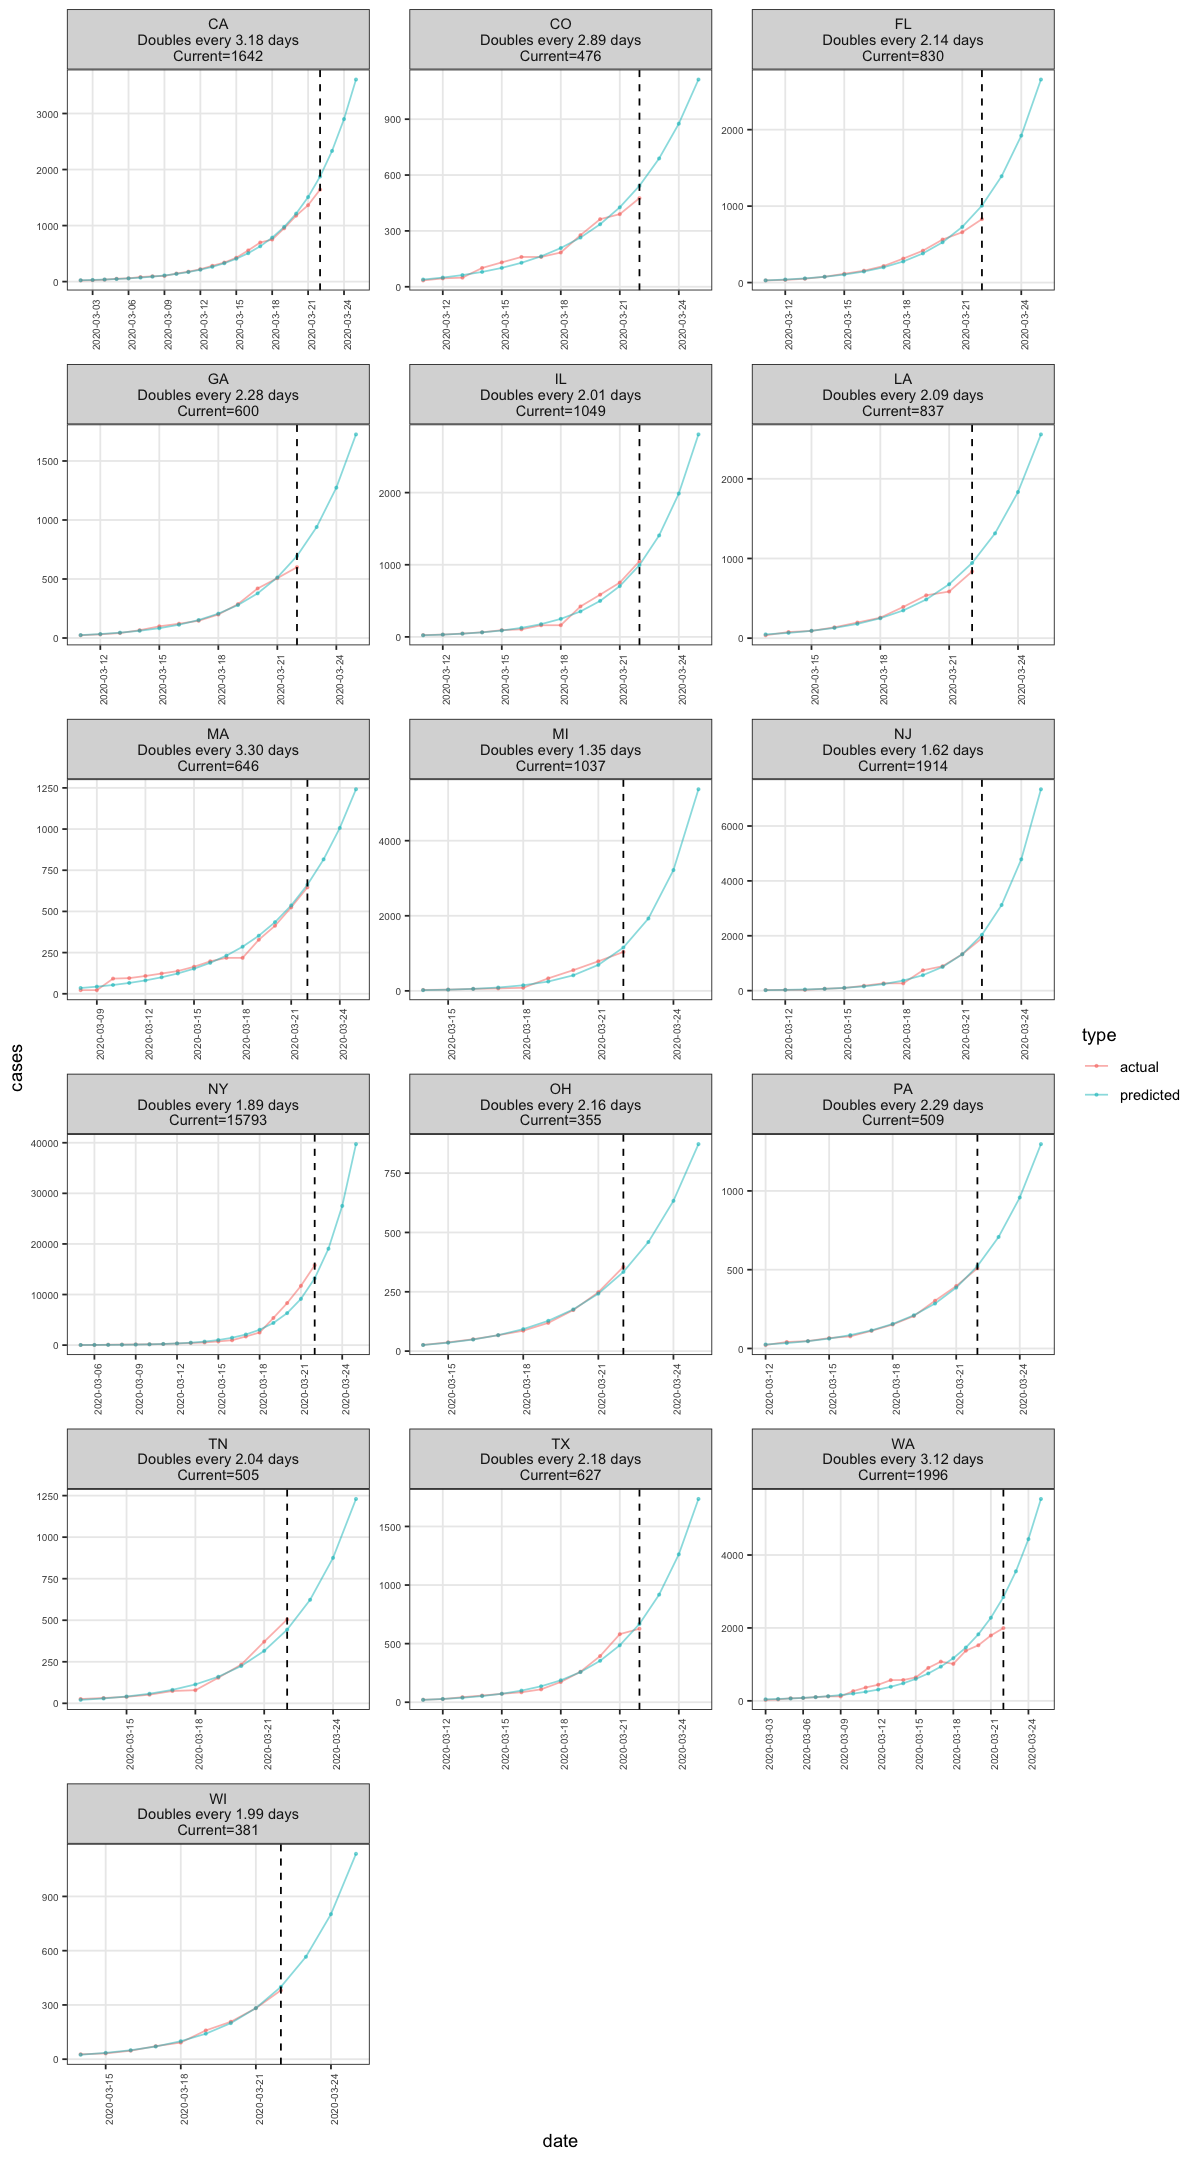

In [1320]:
options(repr.plot.height=18, repr.plot.width=10)
ggplot(state_forecasts,
       aes(x=date, y=cases, color=type)) +
geom_line(alpha=.5) + 
geom_point(size=.5, alpha=.5) +
geom_vline(data=state_forecasts, color='black', aes(xintercept=today), lty=2) +
facet_wrap(~region_label, scale='free', ncol=3) +
scale_x_date(date_breaks='3 days') +
theme(axis.text=element_text(size=6), 
      axis.text.x = element_text(angle = 90, hjust = 1),
      panel.grid.minor=element_blank())


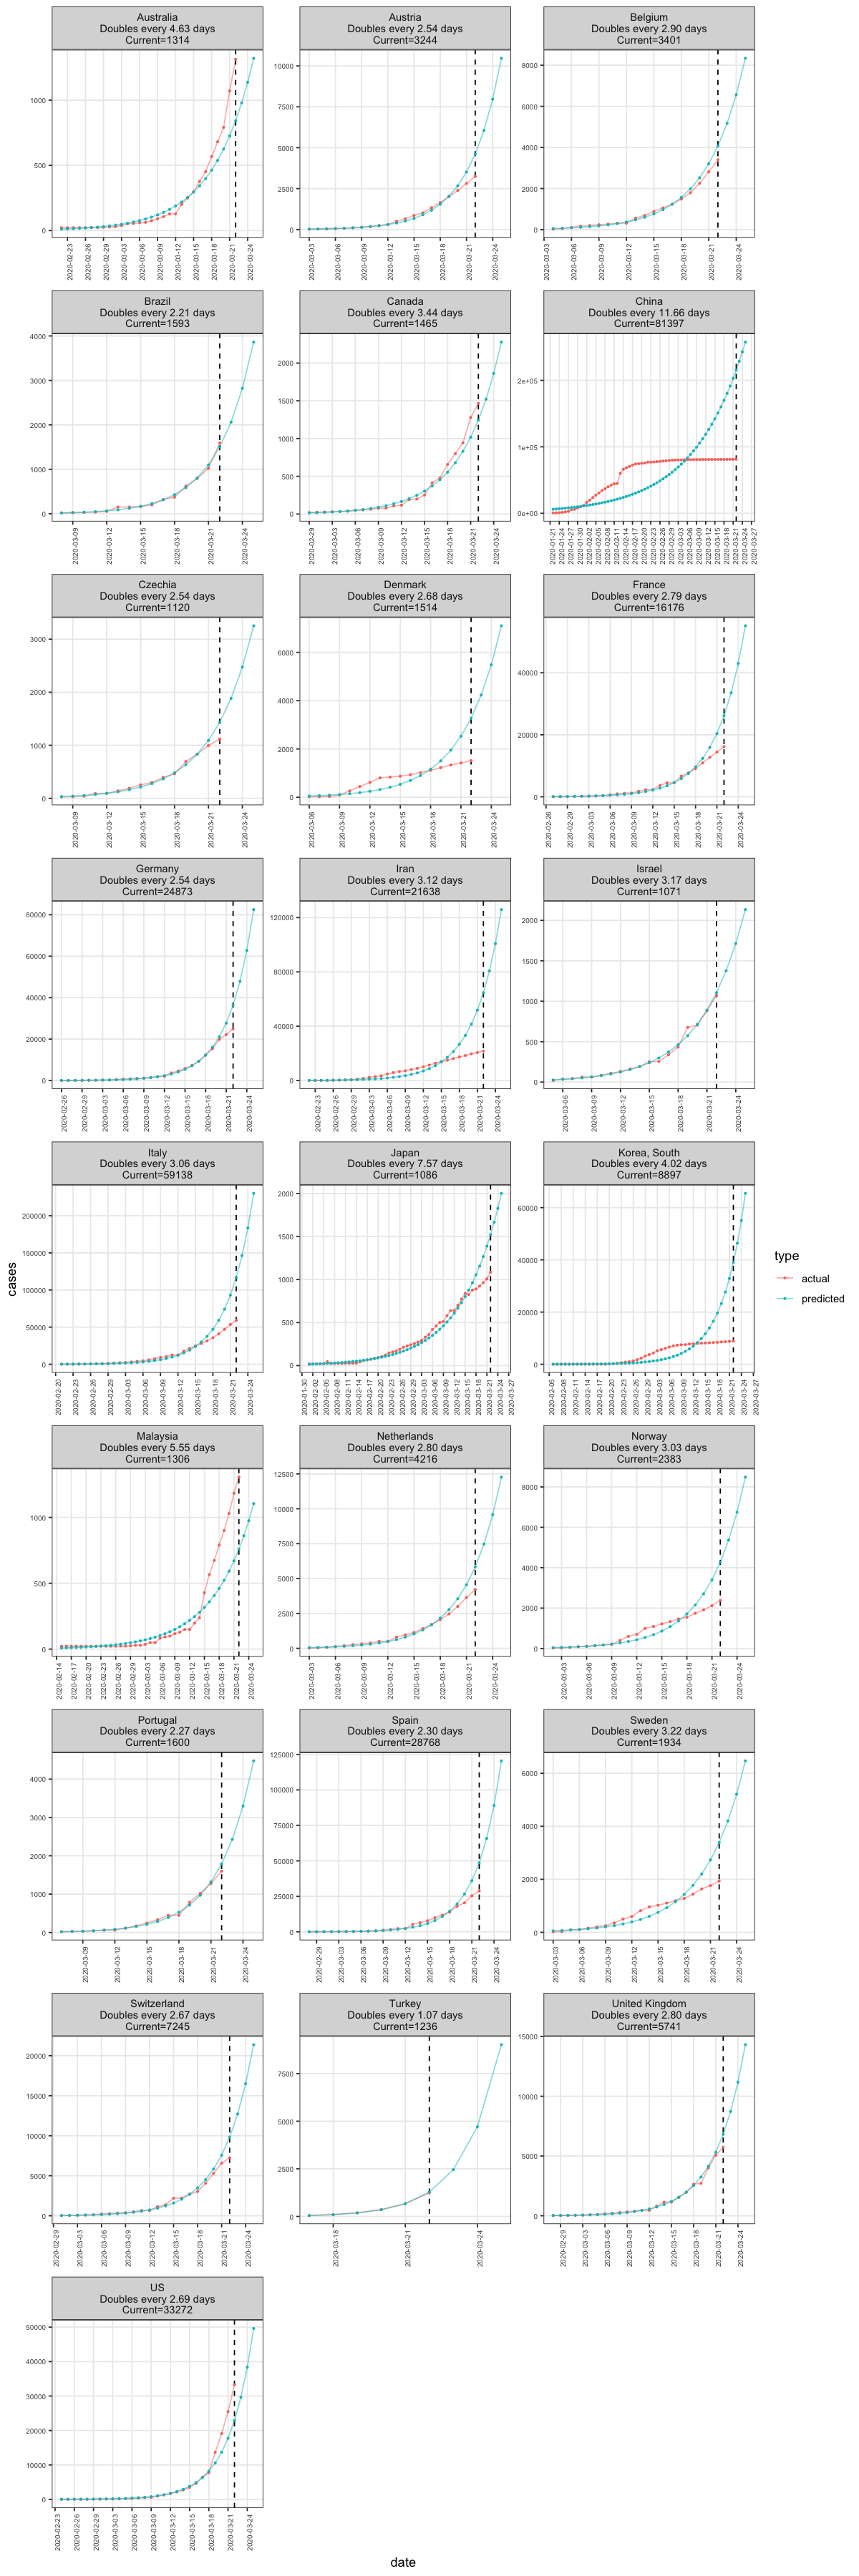

In [1321]:
options(repr.plot.height=30, repr.plot.width=10)
ggplot(country_forecasts,
       aes(x=date, y=cases, color=type)) +
geom_line(alpha=.5) + 
geom_vline(data=country_forecasts, color='black', aes(xintercept=today), lty=2) +
geom_point(size=.5) +
scale_x_date(date_breaks='3 days') +
facet_wrap(~region_label, scale='free', ncol=3) +
theme(axis.text=element_text(size=6), 
      axis.text.x = element_text(angle = 90, hjust = 1),
      panel.grid.minor=element_blank())